In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
%matplotlib inline

In [2]:
pip install tqdm


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
df1 = pd.read_csv(r'card_transdata.csv')
df = pd.DataFrame(df1)
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [40]:
# Conocer la roporción de la variable target
df.fraud.value_counts()

0.0    912597
1.0     87403
Name: fraud, dtype: int64

#### Nuestra variable Target se denomina categorica, siendo (y=1) positivo para Fraude y (y=0) negativo para Fraude

# 1. Construimos matriz de feautres y vector Target

In [77]:
# Construimos la matriz de features donde tomamos todo el DataFrame en la eje X
X = df.iloc[:, 0:-1]
X.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0


In [42]:
# Construimos el vector target Y con la columna Fraud del DF
y = df['fraud']
y.sample(10)

752420    0.0
797352    0.0
436631    0.0
397933    0.0
119928    0.0
784056    0.0
614447    0.0
948637    0.0
59477     0.0
566515    0.0
Name: fraud, dtype: float64

# 2. Diseñamos nuestro Train-Test-Split

In [43]:
# El argumento stratify nos permite generar una división que respeta la misma proporción entre clases en ambos sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=12)

In [44]:
display(y_train.value_counts(normalize=True).round(2))
display(y_test.value_counts(normalize=True).round(2))

0.0    0.91
1.0    0.09
Name: fraud, dtype: float64

0.0    0.91
1.0    0.09
Name: fraud, dtype: float64

# 3. Clasificamos el DF con el modelo KNN

#### Inicialmente tomamos el hiperparametro por defecto, sin estandarizar la matriz

In [45]:
# Importamos la clase KNeighborsClassifier de módulo neighbors
from sklearn.neighbors import KNeighborsClassifier

In [46]:
# Instanciamos el modelo con su configuración por defecto
knn = KNeighborsClassifier()

In [47]:
# Ajustamos a los datos de entrenamiento
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [73]:
# Predecimos etiquetas para los datos de test
y_pred = knn.predict(X_test)

#### Entre los datos de pruebas y prediccion, vemos que se obtiene un 98% de Precision de conincidencia entre la muestra real y la prediccion

In [49]:
# Evaluamos el accuracy del modelo
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred).round(2)

0.98

#### Optimizamos el valor del hiperparametro K, haciendo unsando recall_score tomando un rango de 1 a 10 para posterioirmente determinar el valor optimo en K

In [50]:
recall_score(y_test, y_pred)

0.9247174042377924

In [52]:
#optimizar el valor de K
#from sklearn.model_selection import cross_val_score, KFold
#kf = KFold(n_splits=5, shuffle=True, random_state=12)

scores_para_df = []

for i in tqdm(range(1,10)):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    dict_row_score = {'recall': recall_score(y_test, y_pred), 'n_neighbors':i}
    # Guardamos cada uno en la lista de diccionarios
    scores_para_df.append(dict_row_score)

100%|██████████| 9/9 [04:47<00:00, 31.90s/it]


In [53]:
df_scores = pd.DataFrame(scores_para_df)
df_scores.head()

,recall,n_neighbors
0,0.935930,1
1,0.872958,2
2,0.930163,3
3,0.886229,4
4,0.924717,5


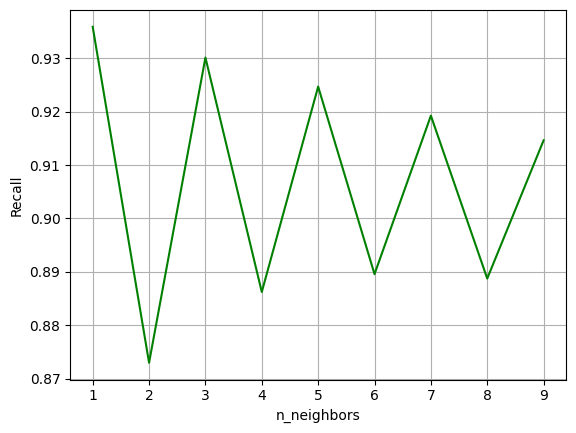

In [78]:
# Graficamos los resultados
plt.plot(df_scores['n_neighbors'], df_scores['recall'], color='g');
plt.xlabel('n_neighbors'); plt.ylabel('Recall')
plt.grid(); plt.show()

#### Validamos cual es el valor que maximiza el score de recall, siendo en este caso el n_neighbors= 1

In [55]:
# Identificamos el score máximo
df_scores.loc[df_scores.recall == df_scores.recall.max()]


,recall,n_neighbors
0,0.93593,1


# 4. Estandarizacion de los datos de train

In [80]:
#Estandarizacion Matriz
# Utilizamos sklearn para estandarizar la matriz de features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [81]:
# Verificamos que las variables ahora tengan media 0 y desvío 1.
print('Medias:', np.mean(X_train, axis=0).round(2))
print('Desvio:', np.std(X_train, axis=0).round(2))

Medias: [ 0.  0.  0.  0. -0. -0.  0.]
Desvio: [1. 1. 1. 1. 1. 1. 1.]


In [86]:
# Calculamos nuevamente los scores de Recall pero esta vez sobre los features estandarizados:

scores_para_df_standard = []

for i in tqdm(range(1,10)):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    dict_row_score = {'recall': recall_score(y_test, y_pred), 'n_neighbors':i}
    # Guardamos cada uno en la lista de diccionarios
    scores_para_df_standard.append(dict_row_score)

c:\Users\Laptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\Laptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\Laptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\Laptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\Laptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature nam

In [88]:
# Creamos el DataFrame a partir de la lista de diccionarios
df_scores_standard = pd.DataFrame(scores_para_df_standard)
df_scores_standard

,recall,n_neighbors
0,0.786234,1
1,0.619056,2
2,0.652098,3
3,0.630131,4
4,0.650451,5
5,0.628072,6
6,0.651824,7
7,0.633106,8
8,0.655256,9


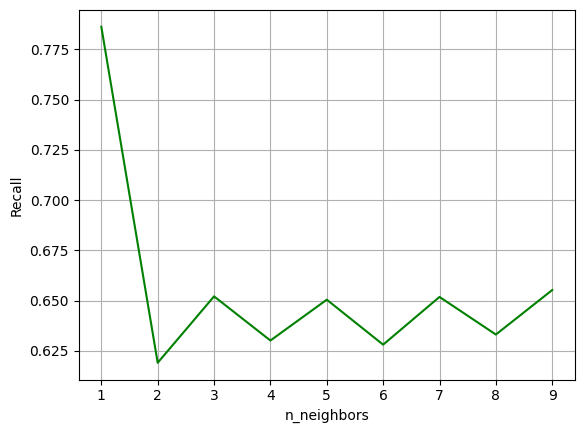

In [92]:
# Graficamos los resultados
plt.plot(df_scores_standard['n_neighbors'], df_scores_standard['recall'], color='g');
plt.xlabel('n_neighbors'); plt.ylabel('Recall')
plt.grid(); plt.show()

Ahora obteniendo el valor optimo, conseguido en el paso anterioir, hacemos de nuevo el entramiento de los datos

In [94]:
# Asignamos el valor del k óptimo a una variable
best_k = df_scores_standard.loc[df_scores.recall == df_scores.recall.max(), 'n_neighbors'].values[0]
best_k

1

In [95]:
# Elegimos el modelo óptimo de acuerdo a las pruebas de recall_score
model = KNeighborsClassifier(n_neighbors=best_k)

# Lo ajustamos sobre los datos de entrenamiento
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

#### Obtenemos un ajuste cerca de 100%

In [96]:
# Evaluamos qué accuracy obtenemos en train
accuracy_score(y_train, model.predict(X_train)).round(2)

1.0

# 5. MATRIZ DE CONFUSION

In [98]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 62397, 165752],
       [  7533,  14318]], dtype=int64)

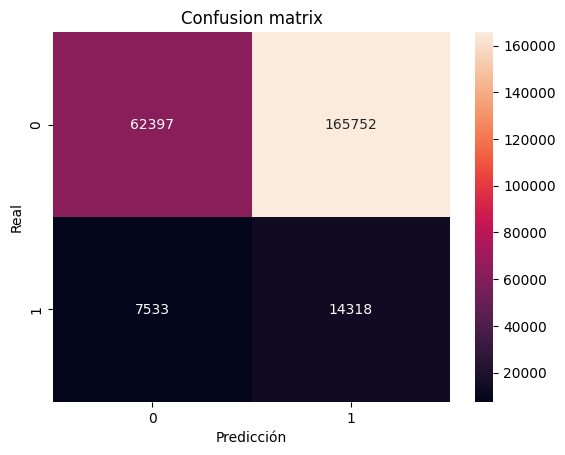

In [99]:
sns.heatmap(cm, annot=True, fmt='.0f')
plt.title("Confusion matrix")
plt.ylabel('Real')
plt.xlabel('Predicción');
plt.show()


* Casos negativos reales 62.397, correspondientes a la primera fila.

* Casos positivos reales 14.318, correspondientes a la segunda fila.

* Casos negativos predichos, corresponden a la primera columna.

* Casos positivos predichos, corresponden a la segunda columna.

* Diagonal en la matriz corresponde a las clasificaciones correctas. Siendo 62.397 casos negativos y 14.318 a casos positivos de Fraude.
Los Elementos de la diagonal inversa, nuestro modelo los confude siendo 165.752 casos mal etiquetado para negativo y 7.533 para positivo de fraude.

* Finalmente calculamos la exactitud de nuestro modelo, de manera manual y computada, siendo ambas de precision del 92%

In [100]:
((cm[0,0] + cm[1,1]) / len(y_pred)).round(2)

0.31

In [101]:
accuracy_score(y_test, y_pred).round(2)

0.31